In [1]:
# Fill in your name using the format below and student ID number
your_name = "JORIS, WILLEMS"
student_id = "0908753"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# # Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi WILLEMS, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './models/'

In [8]:
# #Uncomment to link Colab notebook to Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
# import os
# oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

print("input shape: {} \nlabel shape: {}".format(Xr.shape, yr.shape))

input shape: (99289, 32, 32, 3) 
label shape: (99289, 10)


In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

print("Training\ninput shape: {} \nlabel shape: {}".format(X_train.shape, y_train.shape))
print("\nValidation\ninput shape: {} \nlabel shape: {}".format(X_val.shape, y_val.shape))
print("\nTest\ninput shape: {} \nlabel shape: {}".format(X_test.shape, y_test.shape))

Training
input shape: (63544, 32, 32, 3) 
label shape: (63544, 10)

Validation
input shape: (15887, 32, 32, 3) 
label shape: (15887, 10)

Test
input shape: (19858, 32, 32, 3) 
label shape: (19858, 10)


Check the formatting - and what the data looks like

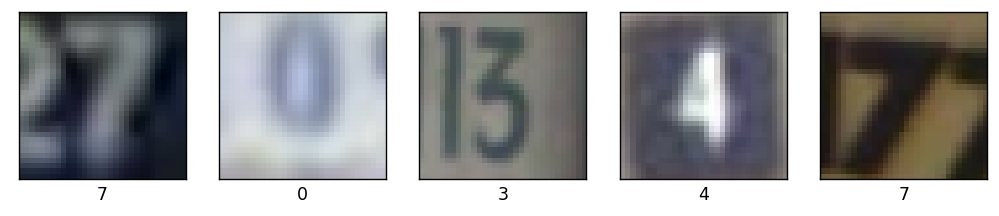

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [83]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension"""
    try:
    # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
    # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model


def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension"""
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
      shout("Loading model from file", verbose)
      model = load_model_from_file(base_dir, name)
      if not model:
          shout("Model not found")
          return
      learning_curves = None
      try:
          learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
      except FileNotFoundError:
          shout("Learning curves not found")
          return
      shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Using TensorFlow backend.


Loading model from file
Success!
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_218 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_219 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_220 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_221 (Dense)            (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.450425  0.270930

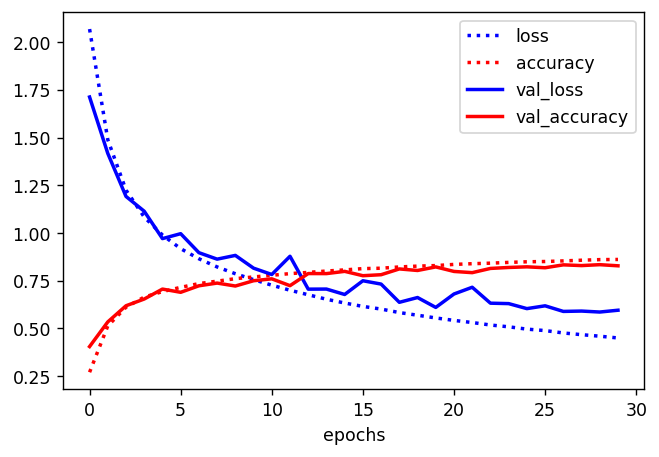

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers 
from keras import regularizers


def build_model_1_1():

  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))

  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=30, batch_size=32)

answer_q_1_1 = """Softmax on output layer and categorial cross entropy are well-suited for multi-class classification. 
ReLU was chosen over sigmoid for computational reasons and similar performance. Starting point was a
 deep network (10 layers) which certainly has enough capacity to (over)fit training data. We 
 regularise by step-wise reducing layers/neurons until the model (almost) starts underfitting. Some 
 optimisers had bad performance (e.g. adam, adagrad). SGD had fast convergence and good performance."""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [16]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

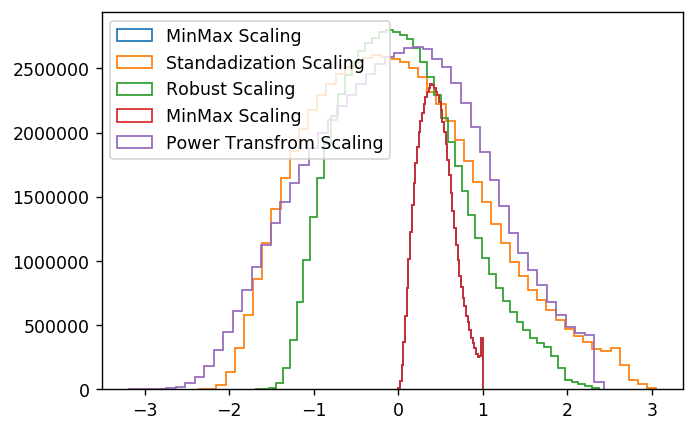

In [17]:
import pylab as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer

def scaleData(scaler):
  X_trainGrey = rgb2gray(X_train).reshape(X_train.shape[0], 32**2)
  X_valGrey = rgb2gray(X_val).reshape(X_val.shape[0], 32**2)
  scaler.fit(X_trainGrey)
  return scaler.transform(X_trainGrey), scaler.transform(X_valGrey), y_train, y_val

datahist = rgb2gray(X_train).flatten()*255
_ = plt.hist(datahist/255, bins=50, label='MinMax Scaling', histtype='step')
_ = plt.hist(scaleData(StandardScaler())[0].flatten(), bins=50, label='Standadization Scaling', histtype='step')
_ = plt.hist(scaleData(RobustScaler())[0].flatten(), bins=50, label='Robust Scaling', histtype='step')
_ = plt.hist(datahist/255, bins=50, label='MinMax Scaling', histtype='step')
_ = plt.hist(scaleData(PowerTransformer())[0].flatten(), bins=50, label='Power Transfrom Scaling', histtype='step')
plt.legend()


Loading model from file
Success!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.325007  0.553852  0.5

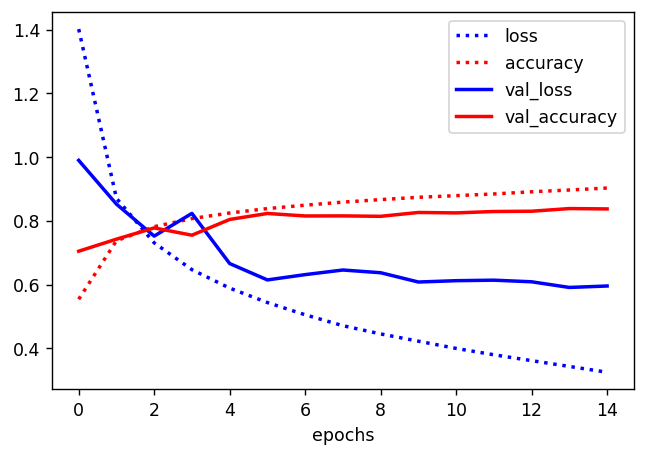

In [18]:
from tensorflow.keras import models
from tensorflow.keras import layers 
from keras import regularizers

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

#logscaling 
# preprocessed_split = np.log(rgb2gray(X_train)+1), np.log(rgb2gray(X_val)+1), y_train, y_val

#standardisation 
preprocessed_split = scaleData(StandardScaler())

# #RobustScaler
# preprocessed_split = scaleData(RobustScaler())

# #PowerTransformer
# preprocessed_split = scaleData(PowerTransformer())

# Adjusted model
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((32*32,), input_shape=(32**2,)))

  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

#Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=15, batch_size=32)

answer_q_1_2 = """Accuracy with greyscale images was very similar, suggesting that the model is not using colors but shapes to make good predictions. Standardisation/RobustScaling/PowerScaling all show similar performance. The distributions (similar for all methods according to a histogram) of the data after scaling seem to decrease the effect of vanishing/exploding gradients, resulting in faster convergence than the previous model. However, there is more overfitting when trained with same number of epochs."""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_113 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_114 (Dense)   

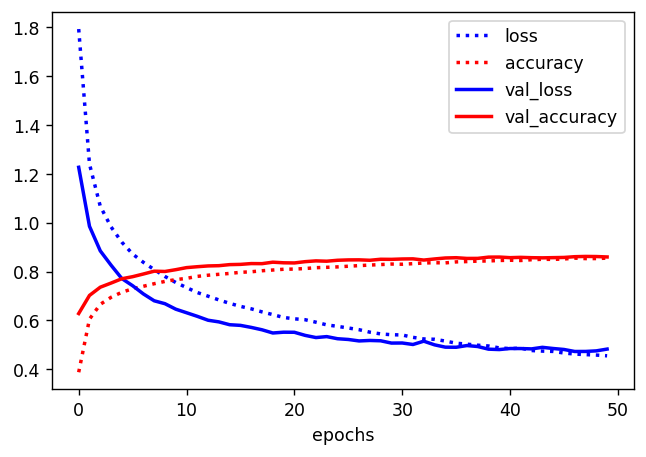

In [19]:
from keras import regularizers
from keras import optimizers
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.015)

preprocessed_split = scaleData(StandardScaler())

def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((32*32,), input_shape=(32**2,)))
  model.add(layers.Dropout(0.15))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.12))

  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.10))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.05))

  model.add(layers.Dense(10, activation='softmax'))
  sgd = SGD(lr=0.015)
  model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=50, batch_size=64)
answer_q_1_3 = """L1/L2 regularisation with different alpha values resulted in less overfitting but lower performance on both training and validation set. Dropout shows better results and enables longer training before overfitting, especially for small rates. Larger batch sizes reduce computation time but if too large (>256), the model got stuck in a local minimum. Learning rates did not significantly improve accuracy, provided that it was not to large (causes overshooting) or small (slow/no learning)."""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_84 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_85 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_160 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_145 (Conv2D) 

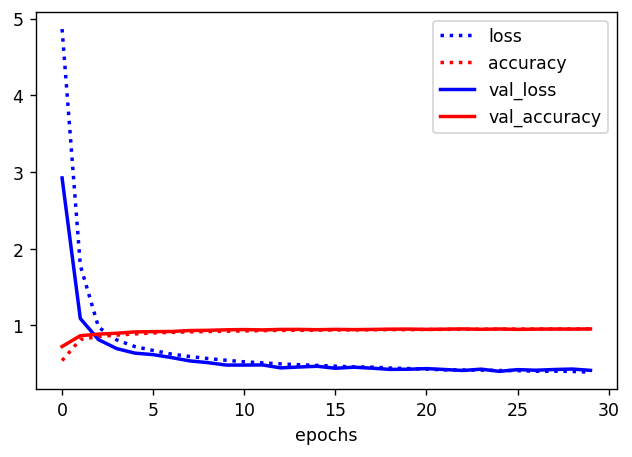

In [20]:
from tensorflow.keras.optimizers import Adam

preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

def build_model_2_1():

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.0007)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(10, activation='softmax'))

  adam = Adam(learning_rate=0.00035)

  model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=30, batch_size=128)

answer_q_2_1 = """Softmax and categorial cross entropy are employed for multi-class classification. A VGG-like architecture with Adam (faster convergence than SGD) results in 93% val-accuracy but showed signs of overfitting. 3 Pooling layers ensure translation invariance. Conv layers have zero padding to maintain image size and deeper layers have increasingly more filters to preserve input information as resolution decreases. Regularising by removing layers/neurons was ineffective. To avoid overfitting, a combination of dropout and batchnormalization (also for faster convergence) is used. Additionally, L1 regularisation on the last hidden layer diminishes the last signs of overfitting. Finally, tuning the learning rate/batch size ensured smooth/fast learning (see learning curves) with no overshooting."""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_246 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_286 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_287 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_248 (Conv2D) 

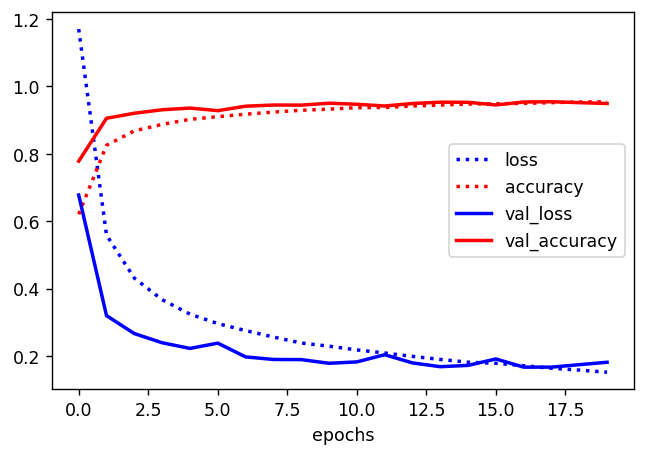

In [21]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def build_model_2_2():

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.20))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.15))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.05))

  model.add(layers.Dense(10, activation='softmax'))

  adam = Adam(learning_rate=0.0003)#learning_rate=0.001

  model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


BATCH = 128

train_datagen = ImageDataGenerator(
    featurewise_center=False, #valt te proberen
    width_shift_range=0.1, #0.2
    height_shift_range=0.1, #0.2
    rotation_range=6,#[20]
    shear_range = 6, #20
    zoom_range = [0.95, 1.05]
)


X_trainGrey, X_valGrey = rgb2gray(X_train), rgb2gray(X_val)

it_train = train_datagen.flow(X_trainGrey, y_train, batch_size=BATCH, shuffle=True)

augmented_split = (it_train, X_valGrey, y_val)

run_evaluation("model_2_2", build_model_2_2, augmented_split, base_dir, 
               train=False, epochs=20, batch_size=BATCH, generator=True, steps_per_epoch=X_train.shape[0]//BATCH)
answer_q_2_2 = """Many transformations are implemented via Keras, but we only apply those transformations that do not change the class (e.g a flipped 6 becomes a 9) or distort too much the digit shape (e.g. too much sheering). Data augmentation is a form of regularization, hence L1 regularisation was removed and dropout reduced. Even though the val_acc is similar to the previous model, it is expected that the network is more robust against small invariances (such as tilted, shifted and digits of different sizes)"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/19858 [==============================] - 10s 499us/sample - loss: 0.1932 - accuracy: 0.9463
Answer is 500 characters long


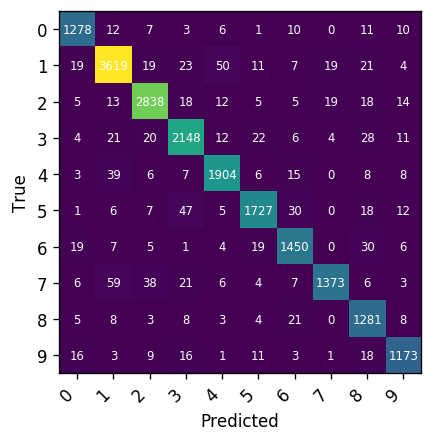

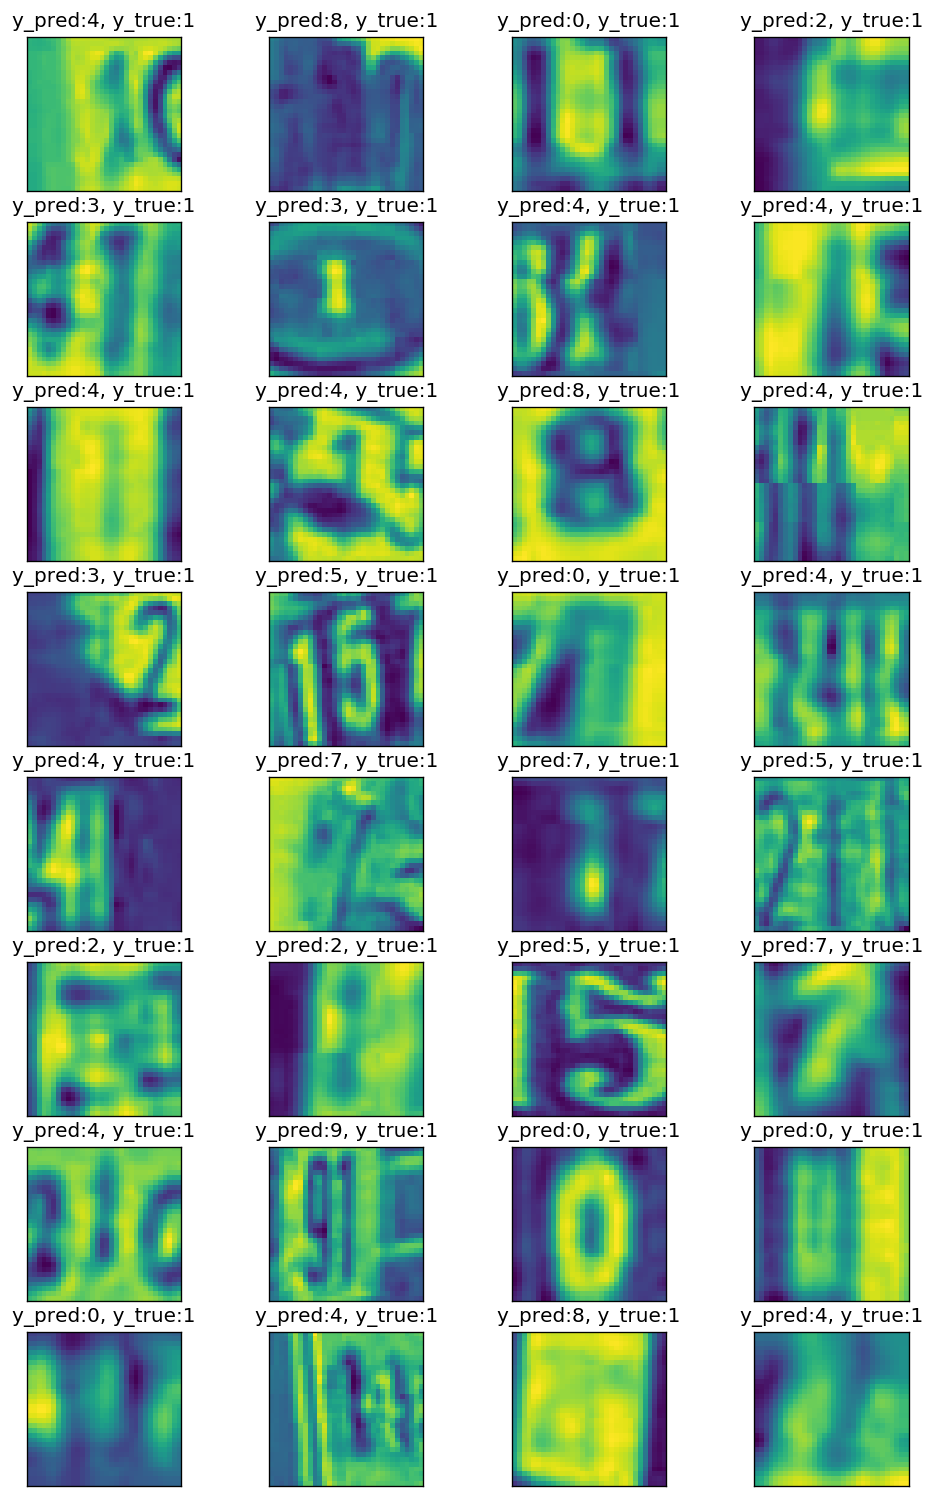

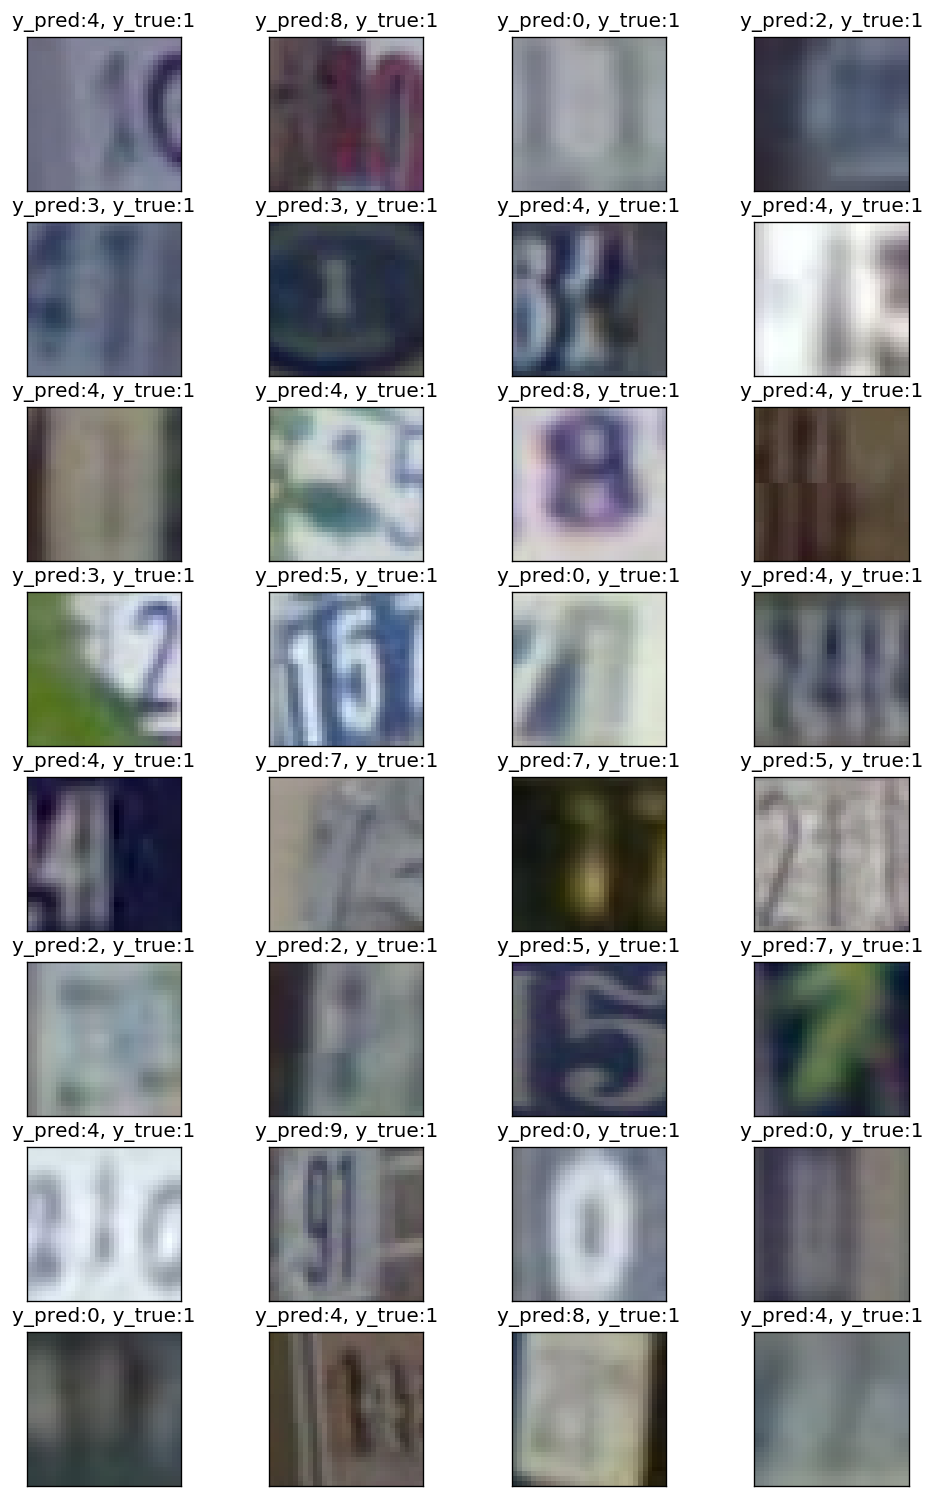

In [39]:
def onehotToNum(onehot):
    return (np.argmax(onehot, axis=-1)+1)%10

model = load_model_from_file(base_dir, "model_2_2")
X_testGrey = rgb2gray(X_test)
test_accuracy_3_1 = model.evaluate(X_testGrey, y_test)[1]

y_pred = onehotToNum(model.predict(X_testGrey, batch_size=500))
y_true = onehotToNum(y_test)

def plot_confusion_matrix():
    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true,y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(np.arange(10)), rotation=45, ha="right")
    ax.set_yticklabels(list(np.arange(10)))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w", fontsize=7)
   
  
def plot_misclassifications():
    
    rows=10; cols=4
    
    trueclass=1; maxplot=32

    showIdx = np.where((y_pred != y_true) & (y_true==trueclass))[0][:maxplot]

    cols=4
    rows = len(showIdx)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2*rows), sharex=True, sharey=True)
    for idx, ax in zip(showIdx, axes.flatten()):
        ax.imshow(X_test[idx, :, :, :])
        ax.set_title("y_pred:{}, y_true:{}".format(y_pred[idx], y_true[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        
def plot_misclassificationsRGB():
    
    rows=10; cols=4
    trueclass=1; maxplot=32                           

    showIdx = np.where((y_pred != y_true) & (y_true==trueclass))[0][:maxplot]

    cols=4
    rows = len(showIdx)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2*rows), sharex=True, sharey=True)
    for idx, ax in zip(showIdx, axes.flatten()):
        ax.imshow(X_testGrey[idx, :, :, 0])
        ax.set_title("y_pred:{}, y_true:{}".format(y_pred[idx], y_true[idx]))
        ax.set_xticks([])
        ax.set_yticks([])
        
plot_confusion_matrix()
plot_misclassificationsRGB()
plot_misclassifications()

    
answer_q_3_1 = """Some misclassifications are explained as (part of) the digit’s shape is similar (e.g 1&7, 2&7, 3&5, 6&8, 6&5). However, distinguishing between a 3 and 1 should be easy as both classes look different, but still errors are made. Closer inspection of class 3’s image data shows that images contain multiple digits, causing ambiguities. Some digits blur with the background, and some digits have been labeled incorrectly. Nonetheless, some misclassifications cannot be explained, indicating model errors."""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

/Users/willems/anaconda3/envs/webret/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Answer is 484 characters long


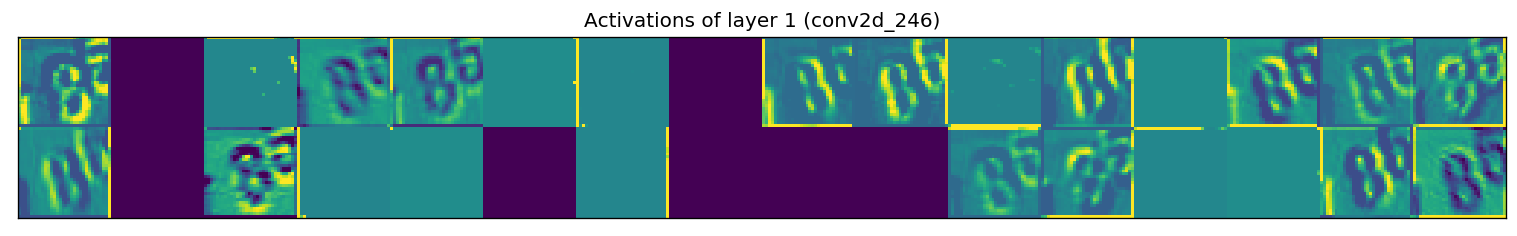

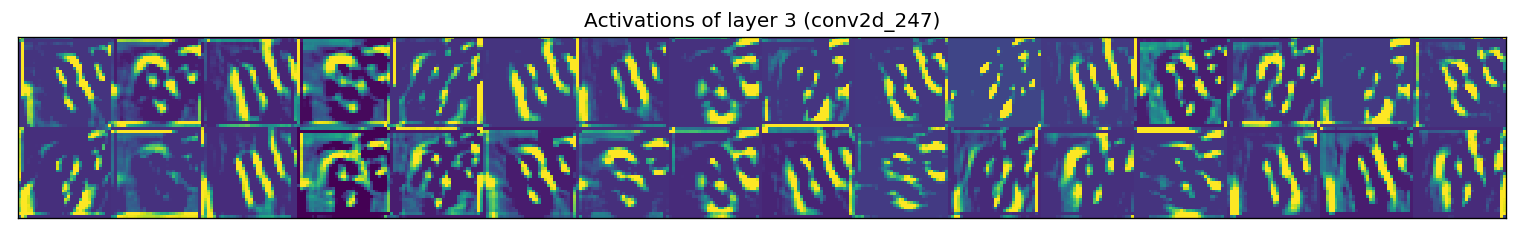

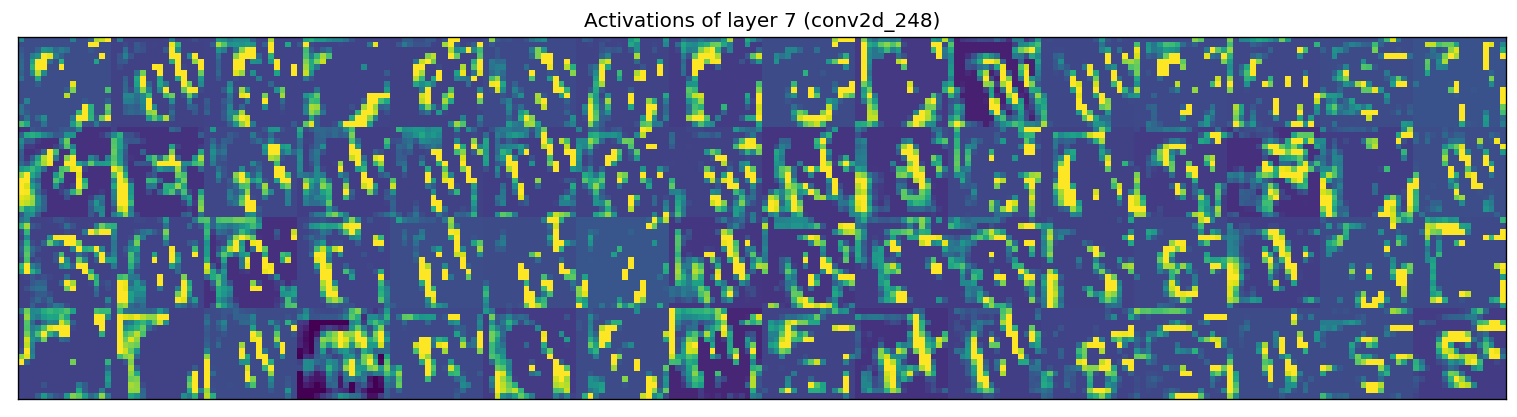

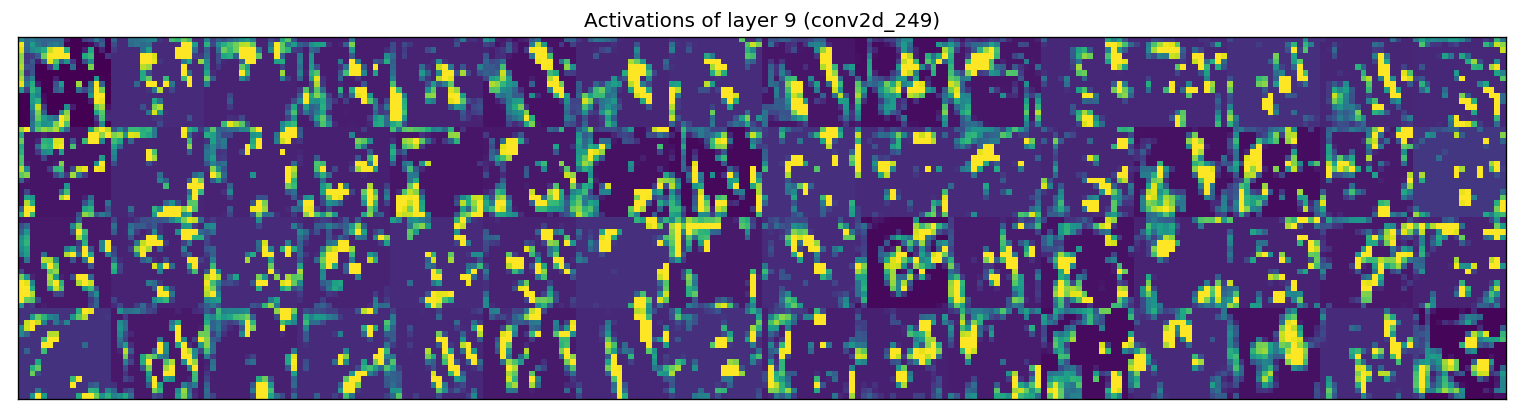

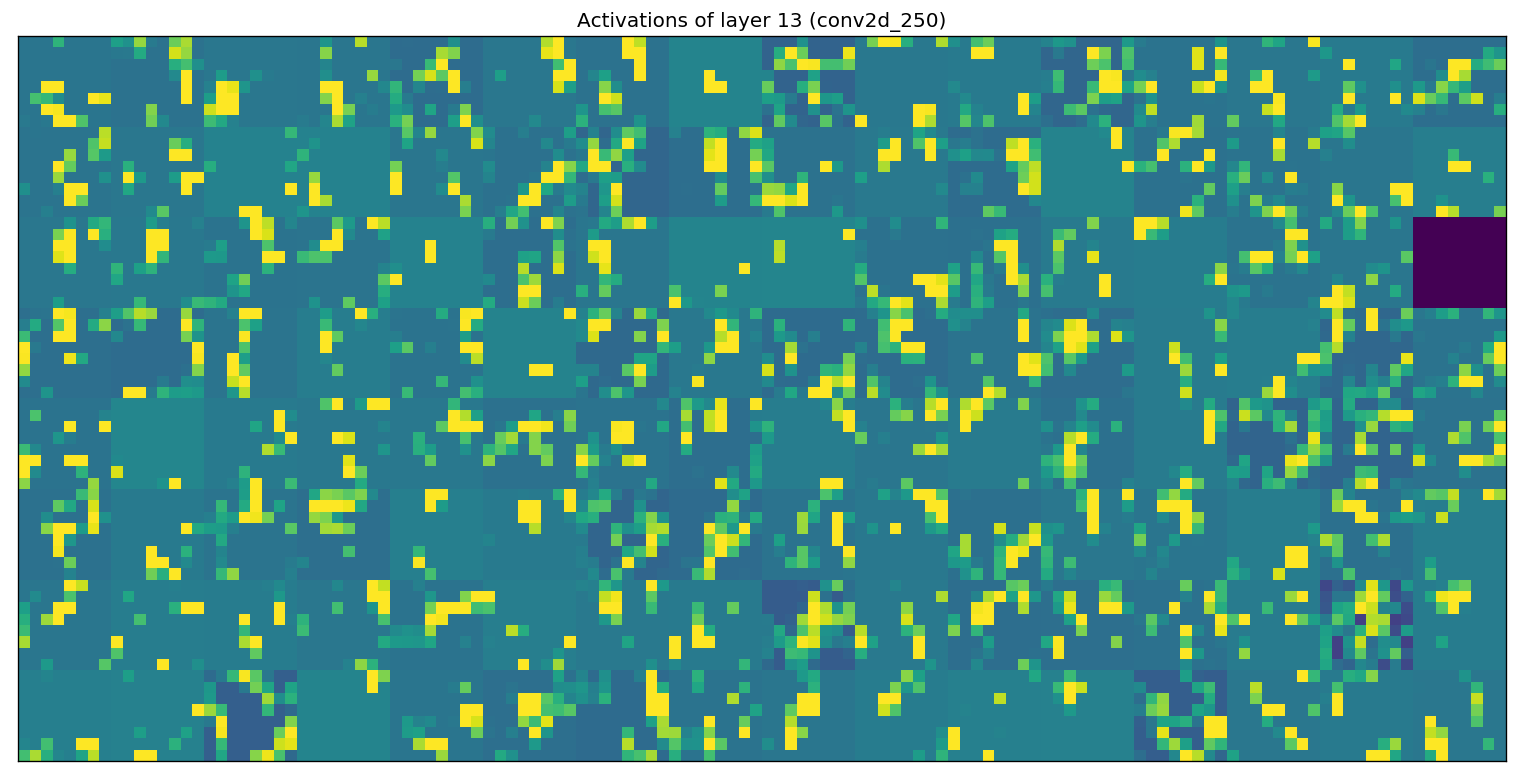

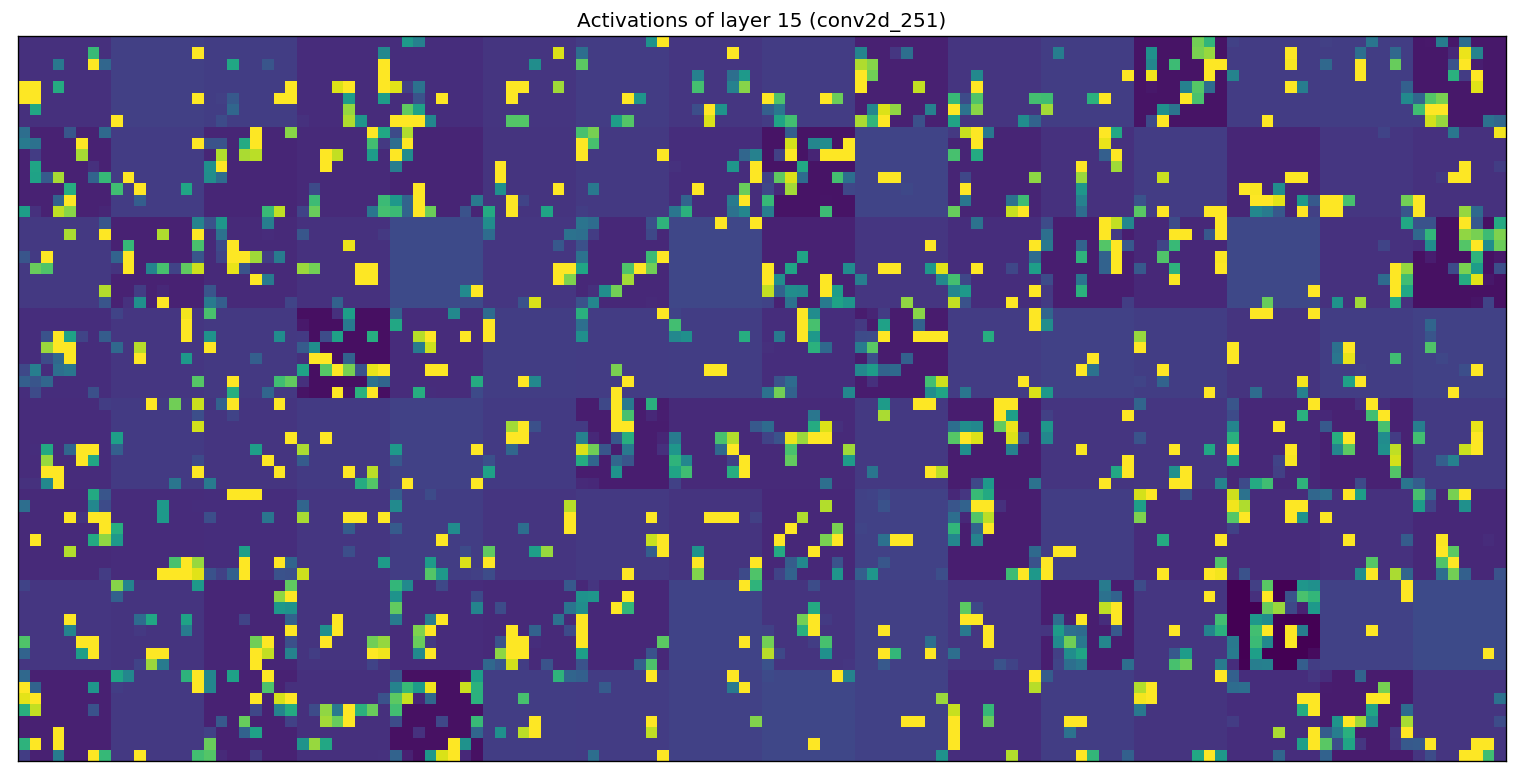

In [45]:
def plot_activations():
    
    from tensorflow.keras import models

    images_per_row = 16; figsize=None
    
    model = load_model_from_file(base_dir, "model_2_2")
    layer_names = ["conv2d_246", "conv2d_247", "conv2d_248", "conv2d_249", "conv2d_250", "conv2d_251"]
    
    for layer_name in layer_names:

        # Extracts the outputs of the top 8 layers:
        layer_outputs = [layer.output for layer in model.layers]
        # Creates a model that will return these outputs, given the model input:
        activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

        input_image = rgb2gray(X_test[0:1]).reshape((1,32,32,1))
        layer_names = np.array([layer.name for layer in model.layers])
        layer_idx = np.where(np.array(layer_names) == layer_name)[0][0]
        activations = activation_model.predict(input_image)[layer_idx:layer_idx+1]

        # Now let's display our feature maps
        for layer_name, layer_activation in zip(layer_names[layer_idx:layer_idx+1], activations):
            # This is the number of features in the feature map
            n_features = layer_activation.shape[-1]

            # The feature map has shape (1, size, size, n_features)
            size = layer_activation.shape[1]

            # We will tile the activation channels in this matrix
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            # We'll tile each filter into this big horizontal grid
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                     :, :,
                                                     col * images_per_row + row]
                    # Post-process the feature to make it visually palatable
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image

            # Display the grid
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title("Activations of layer {} ({})".format(layer_idx+1,layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

            plt.xticks([])
            plt.yticks([])
      
plot_activations()

answer_q_3_2 = """Filters in the first two layers retain the image shape which allows information to propagate through the network. The filters mainly respond to edges or other simple shapes. As we go deeper, for layers 7&9, filters respond to more to details (e.g the 2 holes inside the 8). Even deeper, the activations represent abstract shapes (e.g angles & curves). In the last layer, some filters respond more than others to a certain image, which enables to distinguish/classify different images."""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
0 214
8 174


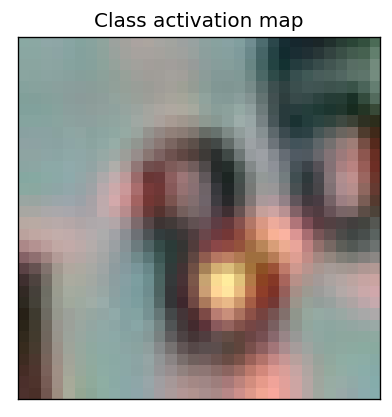

In [28]:
idx=0

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2


def plot_3_3():
    tf.compat.v1.disable_eager_execution()
    model = load_model_from_file(base_dir, "model_2_2")

    # retrieve and preprocess image
    x = rgb2gray(X_test[idx:idx+1]).reshape((1,32,32,1))

    # This is the "8" entry in the prediction vector
    classoutput = model.output[:,np.argmax(model.predict(x), axis=-1)[0]]

    # The is the output feature map of the 'conv2d_251' layer,
    # the last convolutional layer in network
    last_conv_layer = model.get_layer('conv2d_251')

    # This is the gradient of the "8" class with regard to
    # the output feature map of `conv2d_251`
    grads = K.gradients(classoutput, last_conv_layer.output)[0]

    # This is a vector of shape (128,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    # We use cv2 to load the original image
    img = X_test[idx].copy()*255
    img = img.astype(int)

    # We resize the heatmap to have the same size as the original image
    heatmapplot = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmapplot = np.uint8(255 * heatmapplot)
    print(np.min(heatmapplot), np.max(heatmapplot))
    print(np.min(img), np.max(img))
    # We apply the heatmap to the original image
    heatmapplot = cv2.applyColorMap(heatmapplot, cv2.COLORMAP_HOT)

    # 0.5 here is a heatmap intensity factor
    superimposed_img = heatmapplot * 0.5 + img

    # Save the image to disk
    cv2.imwrite('class.jpg', superimposed_img)

    img = cv2.imread('class.jpg')
    RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.dpi'] = 120
    plt.imshow(RGB_im)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Loading model from file
Success!
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_35 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_32 (Batc (None, 128)               512       
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1290      
Total params: 14,782,154
Trainable params: 7,146,634
Non-trainable params: 7,635,520
_

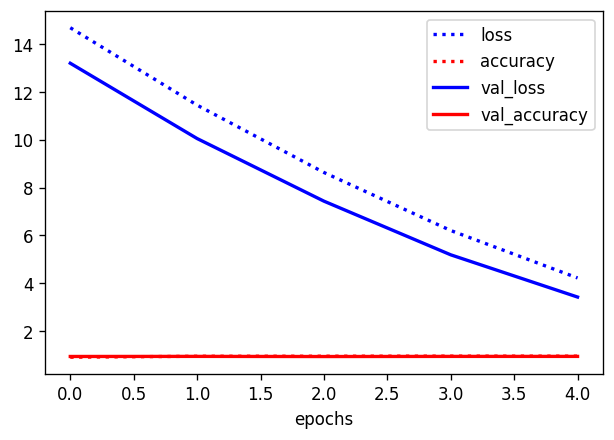

In [82]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras.applications import VGG16

def build_model_4_1():

    conv_base = VGG16(weights='imagenet', 
                      include_top=False,
                      input_shape=(32, 32, 3))
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(l=0.005)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10, activation='softmax'))

    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

BATCH = 512

train_datagen = ImageDataGenerator(
    featurewise_center=False, #valt te proberen
    width_shift_range=0.15, #0.2
    height_shift_range=0.15, #0.2
    rotation_range=8,#[20]
    shear_range = 8, #20
    zoom_range = [0.9, 1.1]
)

it_train = train_datagen.flow(X_train, y_train, batch_size=BATCH, shuffle=True)
augmented_split = (it_train, X_val, y_val)

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer



run_evaluation("model_4_1", build_model_4_1, augmented_split, base_dir, 
               train=False, epochs=5, batch_size=BATCH, generator=True, steps_per_epoch=X_train.shape[0]//BATCH)

answer_q_4_1 = """The last three layers are frozen and a dense layer is added (fine tuning), but this gave less performance than we had before (~80%). This suggests that some non-trainable filters are still adapted to the previous task and not suited for the new task. Unfreezing the last block results in 93% accuracy in just 1 epoch! Small learning rate prevents catastrophic forgetting. Data augmentation, dropout and L1 regularization helps preventing overfitting."""
print("Answer is {} characters long".format(len(answer_q_4_1)))




### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [47]:
import pickle
import gzip, os
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer

def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    from tensorflow.keras import models

    source_model = load_model_from_file(base_dir,"model_4_1")

    model = models.Sequential()
    for layer in source_model.layers[:2]: # go through until last layer
        model.add(layer)
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    X_trainEmbed = model.predict(X_train, batch_size=1000, verbose=True).reshape((X_train.shape[0],512))
    X_valEmbed = model.predict(X_val, batch_size=1000, verbose=True).reshape((X_val.shape[0],512))
    X_testEmbed = model.predict(X_test, batch_size=1000, verbose=True).reshape((X_test.shape[0],512))
    store_embedding(X_trainEmbed, "train")
    store_embedding(X_valEmbed, "val")
    store_embedding(X_testEmbed, "test")
  
def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    clf = SVC(random_state=1, kernel='rbf')
    scaler = MinMaxScaler()
    return Pipeline(steps=[('scaler', scaler),
                          ('classifier', clf)])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    y_trainEmbed = np.argmax(y_train, axis=-1)
    pipeline.fit(X_train, y_trainEmbed)
    y_pred = pipeline.predict(X_test)
    
    return np.mean(np.argmax(y_test, axis=-1) == y_pred)


def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    pipe = generate_pipeline()
    xt = load_embedding("train")
    xv = load_embedding("test")
    return evaluate_pipeline(pipe, xt, y_train, xv, y_test)


print("Accuracy of pipeline on test set={}".format(evaluation_4_2(X_train, y_train, X_test, y_test)))

answer_q_4_2 = """By replacing the last dense and output layer by a non-deep learning technique, we employ the convolutional basis as a feature extractor. The classier then determines the class. I tested svm, random forest, logistic regression with standardization and minmax using stratified 5 fold cross-validation on the training set, all had similar performance (~98%). However, the test score was only 94 suggesting that there might data leaking or imbalenced test set. Tweaking could still improve the results."""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Accuracy of pipeline on test set=0.9413838251586263
Pipeline: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Answer is 498 characters long


In [35]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.preprocessing import StandardScaler,  MinMaxScaler
# from sklearn.model_selection import  StratifiedKFold, cross_validate, GridSearchCV
# import pandas as pd

# ### Helper plotting function. Do not change.
# import seaborn as sns
# def heatmap(columns, rows, scores, title):
#     """ Simple heatmap.
#     Keyword arguments:
#     columns -- list of options in the columns
#     rows -- list of options in the rows
#     scores -- numpy array of scores
#     """
#     df = pd.DataFrame(scores, index=rows, columns=columns)
#     sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")
#     plt.title(title)
    
    
# # Implement
# def plot_1_6(X, y):
#     """ Evaluates 3 classifiers together with 4 types of scaling. See description above.
#     """
#     #define grid
#     grid = {"classifier" :  [SVC(random_state=1, kernel='rbf')],                           
#             "scaler" : [MinMaxScaler()]}
    
#     #Create 3-folds for cross validation
#     kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True) 
    
#     #make pipeline
#     pipe = generate_pipeline(clf=None, scaler=None) 
    
#     #evaluate pipeline on grid
#     grid_res = GridSearchCV(pipe, grid, n_jobs=-1, cv = kfold, scoring="accuracy").fit(X,y)
    
#     #retrieve scores
#     scores = grid_res.cv_results_['mean_test_score'].reshape(len(grid['classifier']),
#                                                             len(grid['scaler']))
#     #visualize
#     heatmap(columns=[p.__class__.__name__ for p in grid['scaler']],
#             rows=[c.__class__.__name__ for c in grid['classifier']],
#             scores=scores,
#             title="Grid Search")
